# Práctica 1

# Carga de Información 

Se cargará la información que será usada para esta practica.

In [2]:
##Importamos algunas librerias que nos servirán en el desarrollo del problema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Cargamos la información que nos ayudará con el modelo

In [4]:
estaturas_data = pd.read_csv("estaturas_Modelo.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_data.ndim)
print('Forma Tensor:',estaturas_data.shape)
print('Vemos los primeros registros de la data:')
estaturas_data.head()

Rango Tensor: 2
Forma Tensor: (29, 2)
Vemos los primeros registros de la data:


,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


Cargamos la información que nos ayudará en las pruebas (Test)

In [8]:
estaturas_test = pd.read_csv("valtest.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_test.ndim)
print('Forma Tensor:',estaturas_test.shape)
print('Veamos los primeros registros de la data:')
estaturas_test.head()

Rango Tensor: 2
Forma Tensor: (8, 2)
Veamos los primeros registros de la data:


,Estatura(metros),Edad(años)
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


Cargamos los datos para la verificación de anomalias.

In [11]:
estaturas_anomalias = pd.read_csv("anomalias.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_anomalias.ndim)
print('Forma Tensor:',estaturas_anomalias.shape)
print('Veamos los primeros registros de la data:')
estaturas_anomalias.head()

Rango Tensor: 2
Forma Tensor: (4, 2)
Veamos los primeros registros de la data:


,Estatura,Edad
0,0.25,2.4
1,175.10,2.5
2,0.15,250.0
3,150.00,14.0


# Hard-Clustering con K-Means

Implementación manual de Metodo de Clasificación No Supervisada usando K-Means. Se implementará una función que en base a la información recibida y un número K determine la clasificación de la información.

1. Creamos una Clase que nos ayudará a entrenar el Modelo

In [333]:
from numpy import random

class K_Means:
    '''Implementación del Algoritmo K_Mean para Clasificación No supervisada'''
    
    def __init__(self, K=2, tol=0.001, max_iter=300):
        '''Constructor de la clase K_Means'''
        ##Inicializamos las varibles que usaremos para controlar el Modelo
        self.K = K
        self.tol = tol
        self.max_iter=max_iter
        
    def fit(self, data):
        '''Metodo para Entrenamiento del Modelo'''
        
        #Armamos los centroides - Números random entre los maximos y minimos de los datos proporcionados
        #Obtenemos Minimos y Maximos
        MinEstatura, MinEdad=np.min(data,axis=0)
        MaxEstatura, MaxEdad=np.max(data,axis=0)
        self.Centroides = np.hstack(((MaxEstatura - MinEstatura)*random.rand(self.K, 1)+MinEstatura,
                                (MaxEdad - MinEdad)*random.rand(self.K, 1)+MinEdad))
        
        #Iteramos para encontrar los centroides del modelo
        for i in range(self.max_iter):
            #Nos servirá para almacenar la clasificación(label) dada para cada valor de X
            clasificaciones = np.array([])
            
            #Para cada valor del vector X
            for _,x_val in enumerate(data):
                #Calculamos la distancia con los centroides
                distancia = [np.linalg.norm(x_val-self.Centroides[k]) for k in range(self.K)]
                #Determinamos el centroide mas cercando
                clasificacion = np.argmin(distancia)
                #Almacenamos la clasificación de acuerdo al centroide mas cercano
                clasificaciones=np.hstack((clasificaciones,clasificacion))
            
            #Almacenamos el valor anterior de los centroides
            old_Centroides =  np.array(self.Centroides)
            #calculamos el valor de los nuevos centroides
            for i in range(self.K):
                ##Solo se recalcula el centroide si tuvo datos que coincidieron con el mismo
                if (np.sum(data[clasificaciones==i])>0):
                    #Nueva ubicación del centroide en base al promedio
                    self.Centroides[i] = np.average(data[clasificaciones==i],axis=0)

            #Vemos si el valor aún no esa optimizado
            optimized= False if np.sum(np.sum(np.abs(self.Centroides- old_Centroides)/old_Centroides*100,axis=1)>self.tol)>0 else True

            #Si el valor ya esta optimizado - Arriba tolerancia - Nos salimos
            if optimized:
                break
    
    #Función de Costo
    def cost_Model(self,data,clasificaciones):
        '''Función que nos ayuda a calcular el costo del Modelo'''
        
        #Calculamos la distancia con los centroides - Elegimos por Dato
        costosxDato = [np.linalg.norm(data[i]-self.Centroides[int(clasificaciones[i])]) for i in range(len(data))]
        #Determinamos el centroide mas cercando
        Costo = np.average(costosxDato)
        
        #devolvemos el Costo
        return Costo
    
    def predict(self,data,calc_centroides):
        '''Función para Predicción en base al Modelo construido por FIT'''
        #Nos servirá para almacenar la clasificación(label) dada para cada valor de X
        clasificaciones = np.array([])
        
        #Para cada valor del vector X
        for _,x_pred in enumerate(data):
            #Calculamos la distancia con los centroides
            distancia = [np.linalg.norm(x_pred-calc_centroides[k]) for k in range(self.K)]
            #Determinamos el centroide mas cercando
            clasificacion = np.argmin(distancia)
            #Almacenamos la clasificación de acuerdo al centroide mas cercano
            clasificaciones=np.hstack((clasificaciones,clasificacion))
        
        return clasificaciones

2. Definimos la Función de Entrenamiento

In [394]:
def entrenamientoKMeans(X, K, epochs):
    
    #Definimos el costo despues del entrenamiento
    costoTrain = float('inf')
    #Modelo Minimo
    ModeloMin = K_Means(K)
    
    for _ in range(epochs):
        #Llamamos a la clase para el Modelo K_Means
        modelK = K_Means(K)

        #Entrenamos el Modelo
        modelK.fit(X)

        #Obtenemos los Labels del Modelo
        labels= modelK.predict(X,modelK.Centroides)
        
        #Costo del Modelo 
        costoM= modelK.cost_Model(X,labels)
        #Si el Costo del Entrenamiento es menor al modelo encontrado
        if costoTrain>costoM:
            costoTrain=costoM
            ModeloMin = modelK
            LabelsMin = labels
            centroides = modelK.Centroides
    
    #Mostramos la grafica del Mejor Modelo
    plt.scatter(X[:,0],X[:,1], c=LabelsMin, cmap='viridis')
    plt.show()
    print("Costo Despues de la Función de Entrenamiento=",costoTrain)
    #Retornamos el modelo que nos 
    return ModeloMin,centroides

3. Creamos la Función para Predicción

In [395]:
def predicciónKMeans(KMeans_Model, Centroides,X):
    
    #Asignamos las etiquetas 
    labels = KMeans_Model.predict(X,Centroides)
    #Mostramos en una grafica donde se ubican los datos de test
    plt.scatter(X[:,0],X[:,1], c=labels, cmap='viridis')
    plt.show()
    ##Retornamos la clasificación 
    return labels

3. Probamos la función de entrenamiento

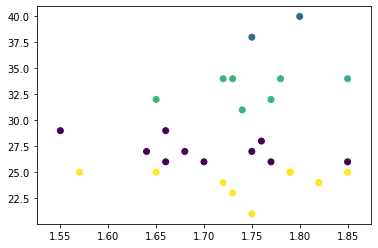

Costo Despues de la Función de Entrenamiento= 0.9842847092363377


In [397]:
X = estaturas_data.values
K = 4
epochs=100
model,centroides = entrenamientoKMeans(X, K, epochs)

4. Probamos la función de Predicción

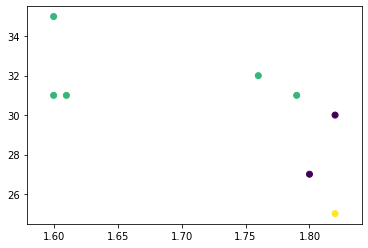

array([3., 0., 2., 2., 0., 2., 2., 2.])

In [400]:
X= estaturas_test.values
predicciónKMeans(model, centroides, X )

# Soft-clustering con GMM

Implementación del Metodo de clasificación con Soft-Clustering usando Scikit-Learn.

1. Creamos la función de entrenamiento.

In [38]:
from sklearn.mixture import GaussianMixture

def entrenamientoGMM(X, K):
    # Entrenamos el modelo con la data recibida
    gmm = GaussianMixture(n_components=K).fit(X)
    # Asignamos las etiquetas a la información recibida
    labels = gmm.predict(X)
    #Mostramos en una grafica como queda la distribución
    plt.scatter(X[:,0],X[:,1], c=labels)
    #Mostramos la grafica
    plt.show()
    #Retornamos el modelo que nos 
    return gmm

2. Creamos la función para la predicción

In [39]:
def predicciónGMM(GMMModel, X):
    
    #Asignamos las etiquetas 
    labels = GMMModel.predict(X)
    #Retornamos la distribución de Probabilidad
    proba = GMMModel.predict_proba(X)
    #Mostramos en una grafica donde se ubican los datos de test
    plt.scatter(X[:,0],X[:,1], c=labels)
    plt.show()
    ##Retornamos la clasificación y la probabilidad
    return labels,proba

3. Pruebas

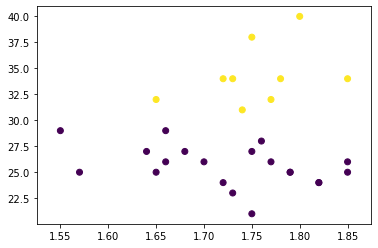

In [42]:
X = estaturas_data.values
model=entrenamientoGMM(X, 2)

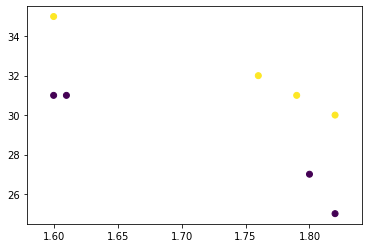

(array([0, 0, 0, 1, 1, 1, 1, 0], dtype=int64),
 array([[9.99780191e-01, 2.19809339e-04],
        [9.88700692e-01, 1.12993076e-02],
        [6.26717298e-01, 3.73282702e-01],
        [1.75287550e-03, 9.98247124e-01],
        [1.81556280e-01, 8.18443720e-01],
        [1.68708432e-03, 9.98312916e-01],
        [1.56825691e-02, 9.84317431e-01],
        [5.13145710e-01, 4.86854290e-01]]))

In [44]:
X= estaturas_test.values
predicciónGMM(model, X)